In [22]:
import json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import pickle
from pathlib import Path


In [23]:
output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')


In [24]:
# Configuration - update these paths as needed
LHS_FILE = "/Users/rem76/PycharmProjects/TLOmodel/src/scripts/climate_disruptions/lhs_parameter_draws.json"
n_samples_to_use = 200
start_index = 0
scenario_names = range(n_samples_to_use)

# Parameters that were varied in LHS
LHS_PARAMS = [
    "scale_factor_prob_disruption",
    "delay_in_seeking_care_weather",
    "scale_factor_reseeking_healthcare_post_disruption",
    "scale_factor_appointment_urgency",
    "scale_factor_severity_disruption_and_delay",
]

In [25]:
def partial_rank_correlation(X: np.ndarray, y: np.ndarray) -> tuple:
    """
    Calculate Partial Rank Correlation Coefficients (PRCC) for each input parameter.

    PRCC measures the linear relationship between each input and the output after
    removing the linear effects of all other inputs, using rank-transformed data.
    """
    n_samples, n_params = X.shape

    # Rank transform all data
    X_ranked = np.apply_along_axis(stats.rankdata, 0, X)
    y_ranked = stats.rankdata(y)

    prcc_values = np.zeros(n_params)
    p_values = np.zeros(n_params)

    for i in range(n_params):
        xi = X_ranked[:, i]
        other_indices = [j for j in range(n_params) if j != i]
        X_others = X_ranked[:, other_indices]

        if len(other_indices) > 0:
            X_others_with_intercept = np.column_stack([np.ones(n_samples), X_others])
            coeffs_xi = np.linalg.lstsq(X_others_with_intercept, xi, rcond=None)[0]
            xi_residuals = xi - X_others_with_intercept @ coeffs_xi
            coeffs_y = np.linalg.lstsq(X_others_with_intercept, y_ranked, rcond=None)[0]
            y_residuals = y_ranked - X_others_with_intercept @ coeffs_y
        else:
            xi_residuals = xi
            y_residuals = y_ranked

        correlation, p_value = stats.pearsonr(xi_residuals, y_residuals)
        prcc_values[i] = correlation
        p_values[i] = p_value

    return prcc_values, p_values

In [26]:
def load_lhs_parameters(lhs_file: str, n_samples: int, start_idx: int) -> pd.DataFrame:
    """Load LHS parameter draws from JSON file."""
    with open(lhs_file, 'r') as f:
        all_samples = json.load(f)
    samples = all_samples[start_idx:start_idx + n_samples]
    df = pd.DataFrame(samples)
    return df[LHS_PARAMS]

# Load the parameters
lhs_params = load_lhs_parameters(LHS_FILE, n_samples_to_use, start_index)
print(f"Loaded {len(lhs_params)} LHS parameter draws")
print(f"Parameters: {lhs_params.columns.tolist()}")

Loaded 200 LHS parameter draws
Parameters: ['scale_factor_prob_disruption', 'delay_in_seeking_care_weather', 'scale_factor_reseeking_healthcare_post_disruption', 'scale_factor_appointment_urgency', 'scale_factor_severity_disruption_and_delay']


In [27]:
print(lhs_params.describe())


       scale_factor_prob_disruption  delay_in_seeking_care_weather  \
count                    200.000000                     200.000000   
mean                       0.976268                      28.319027   
std                        0.566262                      17.721002   
min                        0.006318                       0.097298   
25%                        0.488404                      12.075464   
50%                        0.935533                      28.056465   
75%                        1.469137                      43.020207   
max                        1.994460                      59.777009   

       scale_factor_reseeking_healthcare_post_disruption  \
count                                         200.000000   
mean                                            0.958776   
std                                             0.574277   
min                                             0.000886   
25%                                             0.426698   
50%      

In [49]:
lhs_params = load_lhs_parameters(LHS_FILE, n_samples_to_use, start_index)
print(f"Loaded {len(lhs_params)} LHS parameter draws")
print(f"Parameters: {lhs_params.columns.tolist()}")

# Find draws where scale_factor_prob_disruption > 1.5
high_scale_draws = lhs_params[lhs_params['scale_factor_prob_disruption'] < 0.5]

print(f"\nDraws with scale_factor_prob_disruption > 1.5:")
print(high_scale_draws[['scale_factor_prob_disruption']])
print(f"\nDraw indices: {high_scale_draws.index.tolist()}")
print(f"Count: {len(high_scale_draws)}")

Loaded 200 LHS parameter draws
Parameters: ['scale_factor_prob_disruption', 'delay_in_seeking_care_weather', 'scale_factor_reseeking_healthcare_post_disruption', 'scale_factor_appointment_urgency', 'scale_factor_severity_disruption_and_delay']

Draws with scale_factor_prob_disruption > 1.5:
     scale_factor_prob_disruption
0                        0.170726
1                        0.446174
5                        0.241233
10                       0.450426
17                       0.346531
18                       0.038145
21                       0.494922
28                       0.172895
39                       0.056857
44                       0.408169
47                       0.060842
49                       0.272794
53                       0.387165
54                       0.306511
56                       0.160993
61                       0.120348
67                       0.320233
72                       0.278356
75                       0.258548
80                       0.3

In [28]:
def calculate_prcc_by_year(lhs_params, output_by_draw, target_years):
    """Calculate PRCC for each year separately."""
    X = lhs_params.values
    param_names = lhs_params.columns.tolist()
    n_draws = len(lhs_params)
    results = []

    for year in target_years:
        y = np.zeros(n_draws)
        for draw_idx in range(n_draws):
            if draw_idx in output_by_draw and year in output_by_draw[draw_idx]:
                val = output_by_draw[draw_idx][year]
                if isinstance(val, pd.Series):
                    y[draw_idx] = val.values[0] if len(val) > 0 else np.nan
                elif isinstance(val, (int, float)):
                    y[draw_idx] = val
                else:
                    y[draw_idx] = np.nan
            else:
                y[draw_idx] = np.nan

        valid_mask = ~np.isnan(y)
        if valid_mask.sum() < 10:
            warnings.warn(f"Year {year}: Only {valid_mask.sum()} valid draws, skipping")
            continue

        prcc, pvals = partial_rank_correlation(X[valid_mask], y[valid_mask])

        for i, param in enumerate(param_names):
            results.append({
                'year': year,
                'parameter': param,
                'prcc': prcc[i],
                'p_value': pvals[i],
                'significant': pvals[i] < 0.05,
                'n_valid': valid_mask.sum()
            })

    return pd.DataFrame(results)

In [29]:
def calculate_prcc_pooled(lhs_params, output_by_draw, target_years):
    """Calculate PRCC pooled across all years."""
    param_names = lhs_params.columns.tolist()
    n_draws = len(lhs_params)

    X_pooled, y_pooled = [], []

    for draw_idx in range(n_draws):
        for year in target_years:
            if draw_idx in output_by_draw and year in output_by_draw[draw_idx]:
                val = output_by_draw[draw_idx][year]
                if isinstance(val, pd.Series):
                    val = val.values[0] if len(val) > 0 else np.nan
                if not np.isnan(val):
                    X_pooled.append(lhs_params.iloc[draw_idx].values)
                    y_pooled.append(val)

    X_pooled = np.array(X_pooled)
    y_pooled = np.array(y_pooled)

    if len(y_pooled) < 10:
        warnings.warn(f"Only {len(y_pooled)} valid observations, insufficient for PRCC")
        return pd.DataFrame()

    prcc, pvals = partial_rank_correlation(X_pooled, y_pooled)

    results = []
    for i, param in enumerate(param_names):
        results.append({
            'year': 'all_years',
            'parameter': param,
            'prcc': prcc[i],
            'p_value': pvals[i],
            'significant': pvals[i] < 0.05,
            'n_valid': len(y_pooled)
        })

    return pd.DataFrame(results)


In [30]:
def calculate_prcc(lhs_params, output_by_draw, target_years, include_pooled=True):
    """Calculate PRCC by year and optionally pooled across all years."""
    yearly = calculate_prcc_by_year(lhs_params, output_by_draw, target_years)

    if include_pooled:
        pooled = calculate_prcc_pooled(lhs_params, output_by_draw, target_years)
        if len(pooled) > 0:
            return pd.concat([yearly, pooled], ignore_index=True)

    return yearly

In [31]:
def restructure_results_for_prcc(
    all_scenarios_appointment_delayed_mean,
    all_scenarios_appointment_cancelled_mean,
    all_scenarios_dalys_mean,
    scenario_names
):
    """
    Convert scenario-indexed results to draw-indexed results for PRCC.

    Your results are structured as: scenario_name -> year -> value
    PRCC needs: draw_number -> year -> value
    """
    delayed_by_draw = {}
    cancelled_by_draw = {}
    dalys_by_draw = {}

    for draw, scenario in enumerate(scenario_names):
        if scenario == 'Baseline':
            continue

        if scenario in all_scenarios_appointment_delayed_mean:
            delayed_by_draw[draw] = {}
            for year, val in all_scenarios_appointment_delayed_mean[scenario].items():
                if isinstance(val, pd.Series):
                    delayed_by_draw[draw][year] = val.values[0] if len(val) > 0 else 0
                else:
                    delayed_by_draw[draw][year] = val

        if scenario in all_scenarios_appointment_cancelled_mean:
            cancelled_by_draw[draw] = {}
            for year, val in all_scenarios_appointment_cancelled_mean[scenario].items():
                if isinstance(val, pd.Series):
                    cancelled_by_draw[draw][year] = val.values[0] if len(val) > 0 else 0
                else:
                    cancelled_by_draw[draw][year] = val

        if scenario in all_scenarios_dalys_mean:
            dalys_by_draw[draw] = {}
            for year, val in all_scenarios_dalys_mean[scenario].items():
                dalys_by_draw[draw][year] = val

    return delayed_by_draw, cancelled_by_draw, dalys_by_draw

IF FROM COMPARISON_ACTUAL_VS_EXPECTED_DISRUPTION.IPYNB

In [46]:
results

{'delayed': {0: {2025: Facility_ID
   0      0.000000
   1      0.000000
   3      0.001138
   4      0.000000
   5      0.000000
            ...   
   125    0.000000
   127    0.000370
   128    0.000000
   129    0.000000
   130    0.000000
   Name: 0, Length: 99, dtype: float64,
   2026: 0      0.0
   1      0.0
   3      0.0
   4      0.0
   5      0.0
         ... 
   125    0.0
   127    0.0
   128    0.0
   129    0.0
   130    0.0
   Name: 0, Length: 99, dtype: float64,
   2027: 0      0.000000
   1      0.000000
   3      0.000000
   4      0.000000
   5      0.000000
            ...   
   125    0.000000
   127    0.000491
   128    0.000000
   129    0.000000
   130    0.000000
   Name: 0, Length: 99, dtype: float64,
   2028: 0      0.000000
   1      0.000000
   3      0.001102
   4      0.000000
   5      0.000000
            ...   
   125    0.000000
   127    0.000000
   128    0.000000
   129    0.000000
   130    0.000000
   Name: 0, Length: 99, dtype: float64,
   202

In [32]:
with open(f"{output_folder}/scenario_results.pkl", 'rb') as f:
    results = pickle.load(f)

all_scenarios_appointment_delayed_mean = results['delayed']
all_scenarios_appointment_cancelled_mean = results['cancelled']
all_scenarios_dalys_mean = results['dalys']
target_year_sequence = results['target_years']
n_draws = results['n_draws']

In [33]:
delayed_by_draw, cancelled_by_draw, dalys_by_draw = restructure_results_for_prcc(
    all_scenarios_appointment_delayed_mean,
    all_scenarios_appointment_cancelled_mean,
    all_scenarios_dalys_mean,
    scenario_names
)


In [34]:
prcc_delayed = calculate_prcc(lhs_params, delayed_by_draw, target_year_sequence)
prcc_cancelled = calculate_prcc(lhs_params, cancelled_by_draw, target_year_sequence)
prcc_dalys = calculate_prcc(lhs_params, dalys_by_draw, target_year_sequence)


/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_83949/1943965129.py:24: UserWarning: Year 2025: Only 0 valid draws, skipping
  warnings.warn(f"Year {year}: Only {valid_mask.sum()} valid draws, skipping")
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_83949/1943965129.py:24: UserWarning: Year 2026: Only 0 valid draws, skipping
  warnings.warn(f"Year {year}: Only {valid_mask.sum()} valid draws, skipping")
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_83949/1943965129.py:24: UserWarning: Year 2027: Only 0 valid draws, skipping
  warnings.warn(f"Year {year}: Only {valid_mask.sum()} valid draws, skipping")
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_83949/1943965129.py:24: UserWarning: Year 2028: Only 0 valid draws, skipping
  warnings.warn(f"Year {year}: Only {valid_mask.sum()} valid draws, skipping")
/var/folders/1z/j8w4v5lj4k580xt42fkwh7dw0000gn/T/ipykernel_83949/1943965129.py:24: UserWarning: Year 2029: Only 0 valid draws, skipping
  wa

Visualisation

In [35]:
def print_prcc_summary(prcc_df, output_name):
    """Print formatted PRCC summary."""
    print(f"\n{'='*60}")
    print(f"PRCC Results for {output_name}")
    print('='*60)

    yearly_df = prcc_df[prcc_df['year'] != 'all_years']
    pooled_df = prcc_df[prcc_df['year'] == 'all_years']

    if len(yearly_df) > 0:
        pivot = yearly_df.pivot_table(index='parameter', columns='year', values='prcc')
        print("\nPRCC by Year:")
        print(pivot.round(3).to_string())

    if len(pooled_df) > 0:
        print("\nPRCC Pooled Across All Years:")
        for _, row in pooled_df.sort_values('prcc', key=abs, ascending=False).iterrows():
            sig = "*" if row['significant'] else ""
            print(f"  {row['parameter']}: {row['prcc']:.3f}{sig} (n={row['n_valid']})")

    print("\nMost influential (|PRCC| > 0.3):")
    sig = prcc_df[abs(prcc_df['prcc']) > 0.3].sort_values('prcc', key=abs, ascending=False)
    for _, row in sig.iterrows():
        marker = "*" if row['significant'] else ""
        yr = f"year {row['year']}" if row['year'] != 'all_years' else "pooled"
        print(f"  {row['parameter']}: {row['prcc']:.3f} ({yr}){marker}")

In [36]:
# print_prcc_summary(prcc_delayed, "Delayed Appointments")
# print_prcc_summary(prcc_cancelled, "Cancelled Appointments")
# print_prcc_summary(prcc_dalys, "DALYs")


In [37]:
def plot_prcc_tornado(prcc_results_dict, figsize=(15, 5)):
    """Create tornado plots for PRCC results."""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    for ax, (name, df) in zip(axes, prcc_results_dict.items()):
        if len(df) == 0:
            ax.set_title(f'{name}\n(No data)')
            continue

        pooled = df[df['year'] == 'all_years']
        if len(pooled) > 0:
            prcc_vals = pooled.set_index('parameter')['prcc'].sort_values()
            subtitle = "(Pooled)"
        else:
            prcc_vals = df.groupby('parameter')['prcc'].mean().sort_values()
            subtitle = "(Mean)"

        colors = ['#d62728' if x < 0 else '#1f77b4' for x in prcc_vals.values]
        ax.barh(range(len(prcc_vals)), prcc_vals.values, color=colors, alpha=0.8)
        ax.set_yticks(range(len(prcc_vals)))
        ax.set_yticklabels(prcc_vals.index, fontsize=9)
        ax.axvline(0, color='black', linewidth=0.5)
        ax.axvline(0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.axvline(-0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.set_xlabel('PRCC')
        ax.set_title(f'{name}\n{subtitle}')
        ax.set_xlim(-1, 1)

    plt.tight_layout()
    return fig

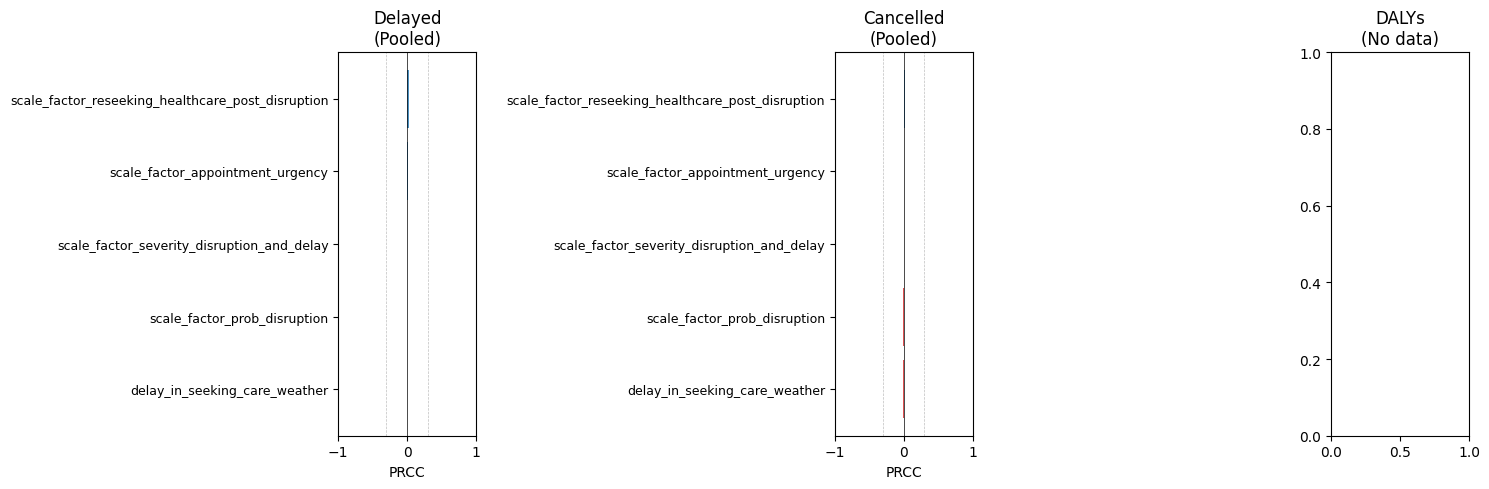

In [38]:
fig = plot_prcc_tornado({
    'Delayed': prcc_delayed,
    'Cancelled': prcc_cancelled,
    'DALYs': prcc_dalys
})
plt.savefig('prcc_tornado.png', dpi=300, bbox_inches='tight')


In [39]:
def plot_prcc_heatmaps(prcc_results_dict, figsize=(15, 5)):
    """Create heatmaps showing PRCC by year."""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    for ax, (name, df) in zip(axes, prcc_results_dict.items()):
        yearly = df[df['year'] != 'all_years']
        if len(yearly) == 0:
            ax.set_title(f'{name}\n(No data)')
            continue

        pivot = yearly.pivot_table(index='parameter', columns='year', values='prcc')

        im = ax.imshow(pivot.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels(pivot.columns)
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index, fontsize=9)
        ax.set_xlabel('Year')
        ax.set_title(f'{name}')

        for i in range(len(pivot.index)):
            for j in range(len(pivot.columns)):
                val = pivot.values[i, j]
                color = 'white' if abs(val) > 0.5 else 'black'
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=color, fontsize=8)

    fig.colorbar(im, ax=axes, shrink=0.6, label='PRCC')
    plt.tight_layout()
    return fig


KeyError: 'year'

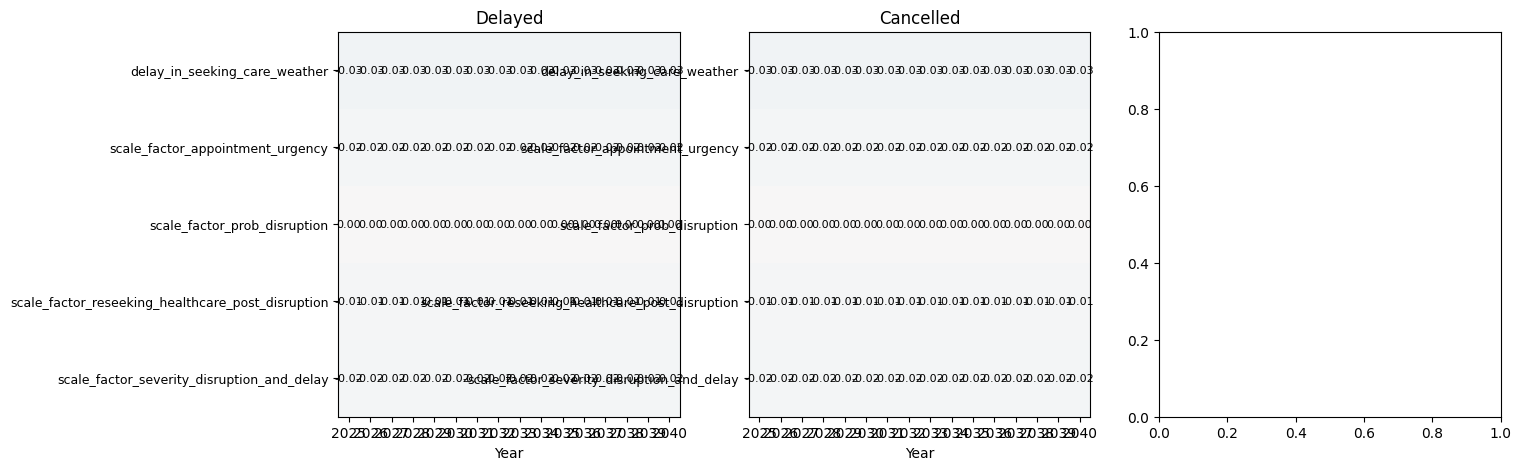

In [45]:
fig = plot_prcc_heatmaps({
    'Delayed': prcc_delayed,
    'Cancelled': prcc_cancelled,
    'DALYs': prcc_dalys
})
plt.savefig('prcc_heatmaps.png', dpi=300, bbox_inches='tight')


Save results

In [41]:
def save_prcc_results(prcc_results_dict, prefix='prcc'):
    """Save PRCC results to CSV files."""
    for name, df in prcc_results_dict.items():
        filename = f"{prefix}_{name.lower().replace(' ', '_')}.csv"
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

# save_prcc_results({
#     'delayed': prcc_delayed,
#     'cancelled': prcc_cancelled,
#     'dalys': prcc_dalys
# })

In [42]:
def prcc_summary_table(prcc_results_dict):
    """Create a summary table of pooled PRCC values across all outputs."""
    rows = []
    for output_name, df in prcc_results_dict.items():
        pooled = df[df['year'] == 'all_years']
        if len(pooled) > 0:
            for _, row in pooled.iterrows():
                rows.append({
                    'Output': output_name,
                    'Parameter': row['parameter'],
                    'PRCC': row['prcc'],
                    'p-value': row['p_value'],
                    'Significant': row['significant']
                })

    summary = pd.DataFrame(rows)
    summary_pivot = summary.pivot_table(
        index='Parameter',
        columns='Output',
        values='PRCC'
    ).round(3)

    return summary_pivot

In [44]:
summary = prcc_summary_table({
    'Delayed': prcc_delayed,
    'Cancelled': prcc_cancelled,
    'DALYs': prcc_dalys
})
display(summary)

KeyError: 'year'